In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


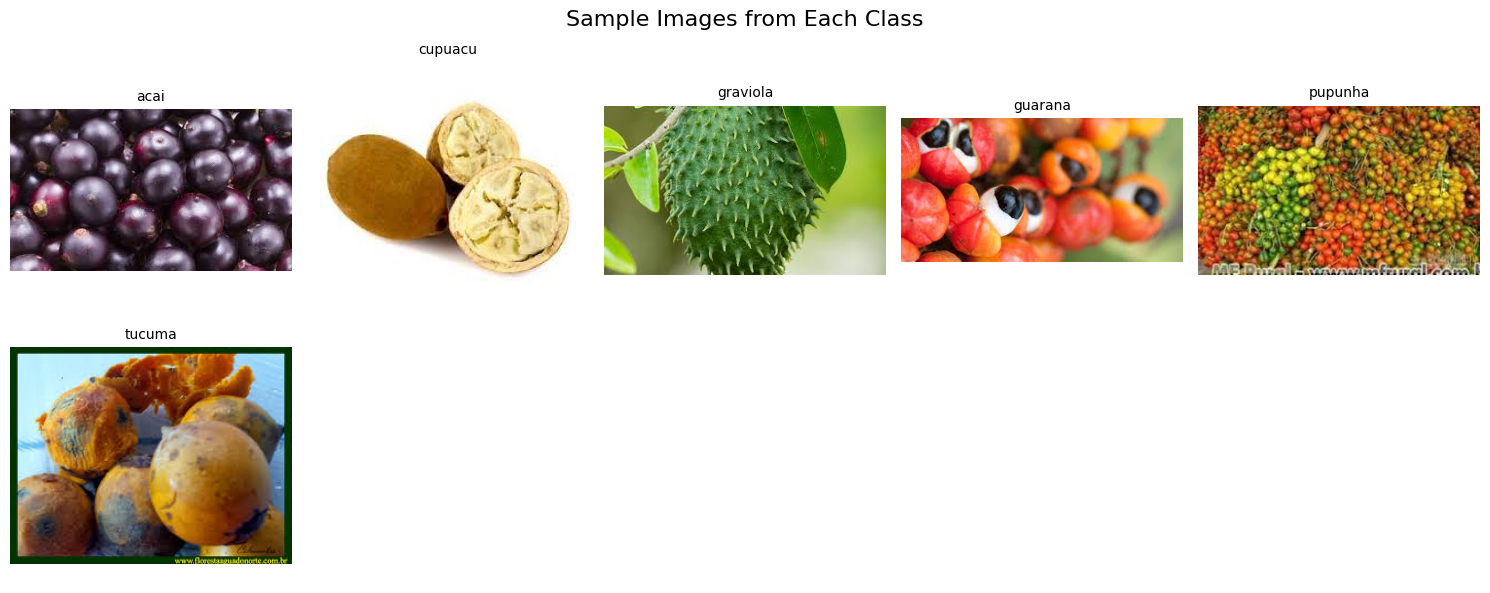

In [3]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_dir = "/content/drive/MyDrive/AiWorkshop/FruitinAmazon/train"

class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

if not class_names:
    raise ValueError("No class directories found in the train folder. Check dataset path!")

selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('png', 'jpg', 'jpeg'))]

    if image_files:
        random_image = random.choice(image_files)
        selected_images.append(os.path.join(class_path, random_image))
        selected_labels.append(class_name)

num_classes = len(selected_images)
if num_classes == 0:
    raise ValueError("No images found in any class folder. Please check dataset.")

cols = min(5, num_classes)
rows = (num_classes // cols) + (num_classes % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
fig.suptitle("Sample Images from Each Class", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < num_classes:
        img = mpimg.imread(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i], fontsize=10)
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()


What did you Observe?

Each image represents a different class, confirming correct dataset structure.
Images vary in resolution, lighting, and orientation.
Some classes may have fewer images, indicating dataset imbalance.
Preprocessing (resizing, normalization) may be needed for consistency.

In [4]:
import os
from PIL import Image
train_dir = "/content/drive/MyDrive/AiWorkshop/FruitinAmazon/train"

corrupted_images = []

for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            try:

                with Image.open(image_path) as img:
                    img.verify()
            except (IOError, SyntaxError):

                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")

if not corrupted_images:
    print("No Corrupted Images Found.")


No Corrupted Images Found.


In [5]:
import tensorflow as tf

img_height = 128
img_width = 128
batch_size = 32
validation_split = 0.2

rescale = tf.keras.layers.Rescaling(1./255)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

train_ds = train_ds.map(lambda x, y: (rescale(x), y))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

val_ds = val_ds.map(lambda x, y: (rescale(x), y))


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(
    optimizer='nadam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [8]:
import tensorflow as tf

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'RenjenSherpa.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.1736 - loss: 1.8149
Epoch 1: val_loss improved from inf to 1.29768, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1823 - loss: 1.8129 - val_accuracy: 0.7778 - val_loss: 1.2977
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.2297 - loss: 1.7812
Epoch 2: val_loss did not improve from 1.29768
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 543ms/step - accuracy: 0.2313 - loss: 1.7742 - val_accuracy: 0.8333 - val_loss: 1.3416
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.3281 - loss: 1.5453
Epoch 3: val_loss did not improve from 1.29768
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - accuracy: 0.3398 - loss: 1.5327 - val_accuracy: 0.0000e+00 - val_loss: 1.9694
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.4988 - loss: 1.2941
Epoch 4: val_loss improved from 1.29768 to 1.19682, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 548ms/step - accuracy: 0.5061 - loss: 1.2901 - val_accuracy: 0.6111 - val_loss: 1.1968
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.4734 - loss: 1.1784
Epoch 5: val_loss improved from 1.19682 to 1.09726, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - accuracy: 0.4835 - loss: 1.1708 - val_accuracy: 0.6667 - val_loss: 1.0973
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.6019 - loss: 0.9441
Epoch 6: val_loss did not improve from 1.09726
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 755ms/step - accuracy: 0.6215 - loss: 0.9275 - val_accuracy: 0.7222 - val_loss: 1.1186
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8507 - loss: 0.6208
Epoch 7: val_loss improved from 1.09726 to 0.82047, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 584ms/step - accuracy: 0.8464 - loss: 0.6265 - val_accuracy: 0.8333 - val_loss: 0.8205
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.8090 - loss: 0.5407
Epoch 8: val_loss improved from 0.82047 to 0.60300, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step - accuracy: 0.8151 - loss: 0.5328 - val_accuracy: 0.7778 - val_loss: 0.6030
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9456 - loss: 0.2856
Epoch 9: val_loss improved from 0.60300 to 0.58871, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 495ms/step - accuracy: 0.9418 - loss: 0.2933 - val_accuracy: 0.8333 - val_loss: 0.5887
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9497 - loss: 0.2887
Epoch 10: val_loss did not improve from 0.58871
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step - accuracy: 0.9518 - loss: 0.2809 - val_accuracy: 0.6667 - val_loss: 0.8891
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9797 - loss: 0.1565
Epoch 11: val_loss improved from 0.58871 to 0.58751, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 508ms/step - accuracy: 0.9813 - loss: 0.1523 - val_accuracy: 0.7778 - val_loss: 0.5875
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9398 - loss: 0.1807
Epoch 12: val_loss improved from 0.58751 to 0.45004, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 707ms/step - accuracy: 0.9410 - loss: 0.1740 - val_accuracy: 0.8889 - val_loss: 0.4500
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 1.0000 - loss: 0.0404
Epoch 13: val_loss improved from 0.45004 to 0.42292, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 728ms/step - accuracy: 1.0000 - loss: 0.0399 - val_accuracy: 0.8889 - val_loss: 0.4229
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 1.0000 - loss: 0.0221
Epoch 14: val_loss did not improve from 0.42292
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 513ms/step - accuracy: 1.0000 - loss: 0.0223 - val_accuracy: 0.8889 - val_loss: 0.4244
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 1.0000 - loss: 0.0160
Epoch 15: val_loss improved from 0.42292 to 0.40543, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - accuracy: 1.0000 - loss: 0.0158 - val_accuracy: 0.8889 - val_loss: 0.4054
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 1.0000 - loss: 0.0113
Epoch 16: val_loss did not improve from 0.40543
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 1.0000 - loss: 0.0110 - val_accuracy: 0.8889 - val_loss: 0.4055
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 1.0000 - loss: 0.0070
Epoch 17: val_loss improved from 0.40543 to 0.39456, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.8889 - val_loss: 0.3946
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 1.0000 - loss: 0.0042
Epoch 18: val_loss improved from 0.39456 to 0.37315, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 835ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.8889 - val_loss: 0.3731
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 1.0000 - loss: 0.0035
Epoch 19: val_loss improved from 0.37315 to 0.36079, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.8889 - val_loss: 0.3608
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 1.0000 - loss: 0.0027
Epoch 20: val_loss improved from 0.36079 to 0.35474, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.8889 - val_loss: 0.3547
Epoch 21/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 21: val_loss did not improve from 0.35474
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.8889 - val_loss: 0.3555
Epoch 22/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 22: val_loss did not improve from 0.35474
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.8889 - val_loss: 0.3615
Epoch 23/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 23: val_loss did not improve from 0.35474
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.8889 - val_loss: 0.3636
Epoch 24/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 24: val_loss did not improve from 0.35474
3/3 

In [9]:
test_dir = '/content/drive/MyDrive/AiWorkshop/FruitinAmazon/test'

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.6667 - loss: 216.6523
Test Loss: 216.65228271484375
Test Accuracy: 0.6666666865348816


In [10]:

model.save('RenjenSherpa_Model.h5')
print("Model saved successfully!")


Model saved successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.44      0.80      0.57         5
           2       0.80      0.80      0.80         5
           3       1.00      0.60      0.75         5
           4       0.80      0.80      0.80         5
           5       0.50      0.40      0.44         5

    accuracy                           0.67        30
   macro avg       0.72      0.67      0.67        30
weighted avg       0.72      0.67      0.67        30

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 1: val_loss improved from 0.35474 to 0.35265, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 579ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.8889 - val_loss: 0.3527
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 1.0000 - loss: 0.0020
Epoch 2: val_loss did not improve from 0.35265
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.8889 - val_loss: 0.3592
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 1.0000 - loss: 0.0019
Epoch 3: val_loss did not improve from 0.35265
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 735ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.8889 - val_loss: 0.3579
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 4: val_loss did not improve from 0.35265
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 442ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.8889 - val_loss: 0.3671
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 5: val_loss did not improve from 0.35265
3/3 ━━━━━━━━

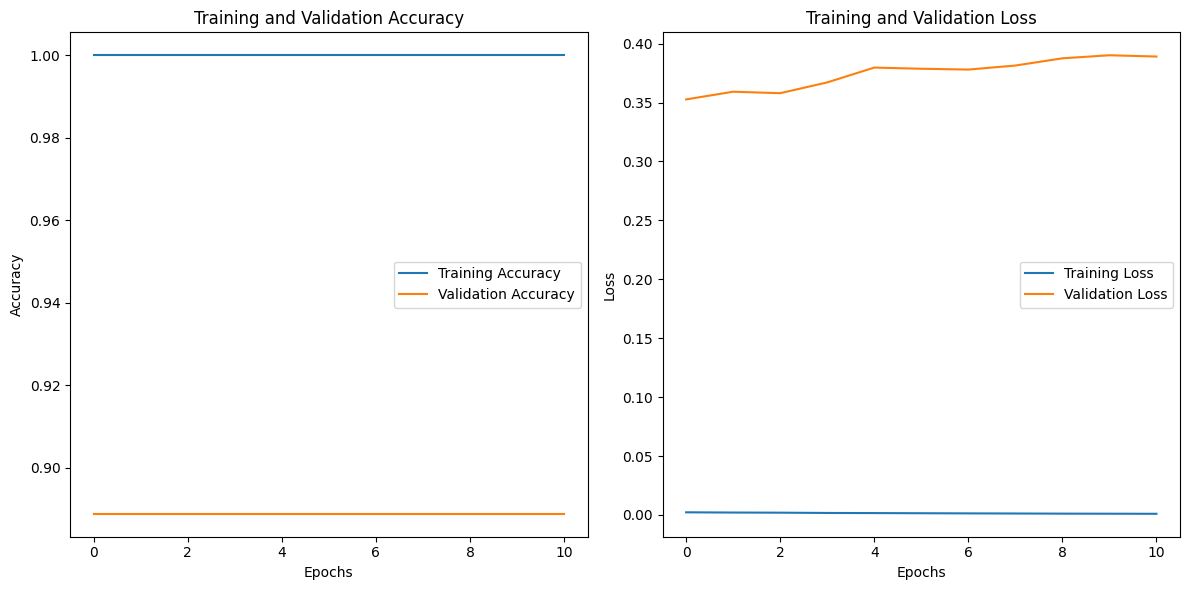

Model saved as 'samip_maharjan_model.h5'


In [11]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

test_images, test_labels = [], []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

model.save('RenjenSherpa_Model.h5')
print("Model saved as 'samip_maharjan_model.h5'")
